<a href="https://colab.research.google.com/github/Foxess/Neural-Nets/blob/main/LSTM_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up the environment

In [ ]:
!pip install tensorflow -qqq
!pip install keras -qqq
!pip install yfinance -qqq

In [2]:
import tensorflow as tf
import keras
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Check TensorFlow version
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.15.0


In [3]:
# Fetch AAPL data
aapl_data = yf.download('AAPL', start='2020-01-01', end='2024-04-30')

# Display the first few rows of the dataframe
aapl_data.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-23,165.350006,167.050003,164.919998,166.899994,166.899994,49537800
2024-04-24,166.539993,169.300003,166.210007,169.020004,169.020004,48251800
2024-04-25,169.529999,170.610001,168.149994,169.889999,169.889999,50558300
2024-04-26,169.880005,171.339996,169.179993,169.300003,169.300003,44838400
2024-04-29,173.369995,176.029999,173.100006,173.500000,173.500000,68169400


In [4]:
# Checking for missing values
missingdata=aapl_data.isnull().sum()
print(missingdata)

# Filling missing values, if any
aapl_data.fillna(method='ffill', inplace=True)

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


# MinMax Normalization to scale data between 0 and 1 without losing information



In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
aapl_data_scaled = scaler.fit_transform(aapl_data['Close'].values.reshape(-1,1))

Creating Sequences
LSTM models require input to be in a sequence format. We transform the data into sequences for the model to learn from.

Defining Sequence Length: Choose a sequence length (like 60 days). This means, for every sample, the model will look at the last 60 days of data to make a prediction.


In [6]:
X = []
y = []

for i in range(60, len(aapl_data_scaled)):
    X.append(aapl_data_scaled[i-60:i, 0])
    y.append(aapl_data_scaled[i, 0])

Train-Test Split
# Split the data into training and testing sets to evaluate the model’s performance properly.

In [7]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshaping Data for LSTM


In [8]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Creating LSTM Layers

In [9]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply

model = Sequential()

# Adding LSTM layers with return_sequences=True
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))

# Integrating the Attention Mechanism:
The attention mechanism can be added to enhance the model’s ability to focus on relevant time steps:

In [10]:
# Adding self-attention mechanism
# The attention mechanism
attention = AdditiveAttention(name='attention_weight')
# Permute and reshape for compatibility
model.add(Permute((2, 1)))
model.add(Reshape((-1, X_train.shape[1])))
attention_result = attention([model.output, model.output])
multiply_layer = Multiply()([model.output, attention_result])
# Return to original shape
model.add(Permute((2, 1)))
model.add(Reshape((-1, 50)))

# Adding a Flatten layer before the final Dense layer
model.add(tf.keras.layers.Flatten())

# Final Dense layer
model.add(Dense(1))

# Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)

# Optimizing the Model
 To enhance the model’s performance and reduce the risk of overfitting, we include Dropout and Batch Normalization.

In [11]:
from keras.layers import BatchNormalization

# Adding Dropout and Batch Normalization
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Model Compilation
Finally, we compile the model with an optimizer and loss function suited for our regression task.

In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')

# Model Summary
It’s beneficial to view the summary of the model to understand its structure and number of parameters.

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 permute (Permute)           (None, 50, 60)            0         
                                                                 
 reshape (Reshape)           (None, 50, 60)            0         
                                                                 
 permute_1 (Permute)         (None, 60, 50)            0         
                                                                 
 reshape_1 (Reshape)         (None, 60, 50)            0         
                                                                 
 flatten (Flatten)           (None, 3000)              0

#Training the Model
Now that our LSTM model with attention is built, it’s time to train it using our prepared training set. This process involves feeding the training data to the model and letting it learn to make predictions.

In [14]:
#WITHOUT EARLY STOPPING
# Assuming X_train and y_train are already defined and preprocessed
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)

Epoch 1/100
27/27 [==============================] - 8s 97ms/step - loss: 0.5649 - val_loss: 0.4603
Epoch 2/100
27/27 [==============================] - 2s 59ms/step - loss: 0.2786 - val_loss: 0.4371
Epoch 3/100
27/27 [==============================] - 2s 58ms/step - loss: 0.2549 - val_loss: 0.4100
Epoch 4/100
27/27 [==============================] - 2s 59ms/step - loss: 0.2247 - val_loss: 0.3787
Epoch 5/100
27/27 [==============================] - 2s 83ms/step - loss: 0.2034 - val_loss: 0.3451
Epoch 6/100
27/27 [==============================] - 2s 78ms/step - loss: 0.1838 - val_loss: 0.3140
Epoch 7/100
27/27 [==============================] - 2s 60ms/step - loss: 0.1650 - val_loss: 0.2858
Epoch 8/100
27/27 [==============================] - 2s 59ms/step - loss: 0.1459 - val_loss: 0.2564
Epoch 9/100
27/27 [==============================] - 2s 58ms/step - loss: 0.1331 - val_loss: 0.2328
Epoch 10/100
27/27 [==============================] - 2s 60ms/step - loss: 0.1165 - val_loss: 0.2196

In [15]:
#WITH EARLYSTOPPING
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
27/27 [==============================] - 2s 84ms/step - loss: 0.0096 - val_loss: 0.0056
Epoch 2/100
27/27 [==============================] - 2s 79ms/step - loss: 0.0096 - val_loss: 0.0078
Epoch 3/100
27/27 [==============================] - 2s 58ms/step - loss: 0.0108 - val_loss: 0.0034
Epoch 4/100
27/27 [==============================] - 2s 57ms/step - loss: 0.0101 - val_loss: 0.0014
Epoch 5/100
27/27 [==============================] - 2s 59ms/step - loss: 0.0102 - val_loss: 0.0017
Epoch 6/100
27/27 [==============================] - 2s 58ms/step - loss: 0.0086 - val_loss: 0.0029
Epoch 7/100
27/27 [==============================] - 2s 60ms/step - loss: 0.0102 - val_loss: 0.0013
Epoch 8/100
27/27 [==============================] - 2s 69ms/step - loss: 0.0098 - val_loss: 0.0070
Epoch 9/100
27/27 [==============================] - 2s 87ms/step - loss: 0.0115 - val_loss: 0.0060
Epoch 10/100
27/27 [==============================] - 2s 56ms/step - loss: 0.0092 - val_loss: 0.0014

In [16]:
#WITH RESTORE BEST WEIGHTS
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
27/27 [==============================] - 2s 76ms/step - loss: 0.0095 - val_loss: 0.0039
Epoch 2/100
27/27 [==============================] - 2s 57ms/step - loss: 0.0115 - val_loss: 0.0092
Epoch 3/100
27/27 [==============================] - 2s 56ms/step - loss: 0.0112 - val_loss: 0.0023
Epoch 4/100
27/27 [==============================] - 2s 58ms/step - loss: 0.0084 - val_loss: 0.0085
Epoch 5/100
27/27 [==============================] - 2s 63ms/step - loss: 0.0085 - val_loss: 0.0033
Epoch 6/100
27/27 [==============================] - 2s 62ms/step - loss: 0.0082 - val_loss: 0.0014
Epoch 7/100
27/27 [==============================] - 3s 93ms/step - loss: 0.0092 - val_loss: 0.0024
Epoch 8/100
27/27 [==============================] - 2s 60ms/step - loss: 0.0081 - val_loss: 0.0061
Epoch 9/100
27/27 [==============================] - 2s 57ms/step - loss: 0.0091 - val_loss: 0.0018
Epoch 10/100
27/27 [==============================] - 2s 57ms/step - loss: 0.0096 - val_loss: 0.0018

# Evaluating with the Test Set
To evaluate the model, we first need to prepare our test data (X_test) in the same way we did for the training data. Then, we can use the model's evaluate function:

In [19]:
# Convert X_test and y_test to Numpy arrays if they are not already
X_test = np.array(X_test)
y_test = np.array(y_test)

# Ensure X_test is reshaped similarly to how X_train was reshaped
# This depends on how you preprocessed the training data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Now evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)

7/7 [==============================] - 0s 17ms/step - loss: 7.0997e-04
Test Loss:  0.0007099743816070259


# Performance Metrics
In addition to the loss, other metrics can provide more insights into the model’s performance. For regression tasks like ours, common metrics include:

Mean Absolute Error (MAE): This measures the average magnitude of the errors in a set of predictions, without considering their direction.
Root Mean Square Error (RMSE): This is the square root of the average of squared differences between prediction and actual observation.

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Making predictions
y_pred = model.predict(X_test)

# Calculating MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)


7/7 [==============================] - 2s 27ms/step
Mean Absolute Error:  0.02163065206825306
Root Mean Square Error:  0.026645342799252045


# Making Predictions
 To predict future stock prices, we need to provide the model with the most recent data points. Let’s assume we have the latest 60 days of data prepared in the same format as X_train: and we want to predict the price for the next day:

In [21]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Fetching the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='60d', interval='1d')

# Selecting the 'Close' price and converting to numpy array
closing_prices = data['Close'].values

# Scaling the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(closing_prices.reshape(-1,1))

# Since we need the last 60 days to predict the next day, we reshape the data accordingly
X_latest = np.array([scaled_data[-60:].reshape(60)])

# Reshaping the data for the model (adding batch dimension)
X_latest = np.reshape(X_latest, (X_latest.shape[0], X_latest.shape[1], 1))

# Making predictions for the next 4 candles
predicted_stock_price = model.predict(X_latest)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

print("Predicted Stock Prices for the next 4 days: ", predicted_stock_price)

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 49ms/step
Predicted Stock Prices for the next 4 days:  [[177.60266]]


# Let’s predict the price for the next 4 days:

In [22]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Fetch the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='60d', interval='1d')

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    # Get the prediction (next day)
    next_prediction = model.predict(current_batch)

    # Reshape the prediction to fit the batch dimension
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)

    # Append the prediction to the batch used for predicting
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)

    # Inverse transform the prediction to the original price scale
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

print("Predicted Stock Prices for the next 4 days: ", predicted_prices)

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step
Predicted Stock Prices for the next 4 days:  [177.60266, 179.16083, 180.50003, 181.30255]


# Visualization of Predictions
Comparing the predicted values with actual stock prices visually can be very insightful. Below is the code to plot the predicted stock prices against the actual data:

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.7 MB/s eta 0:00:00


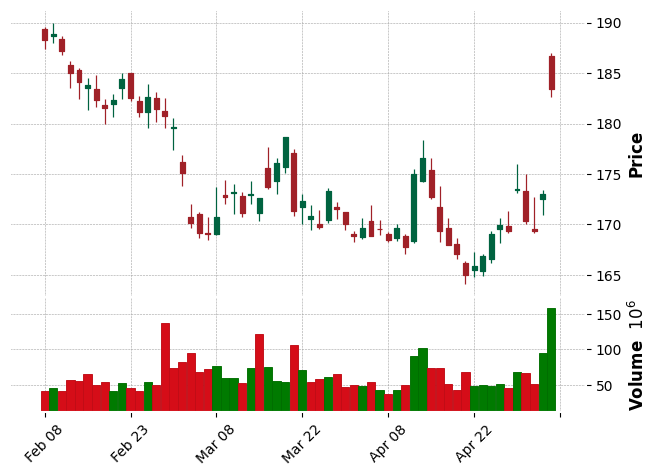

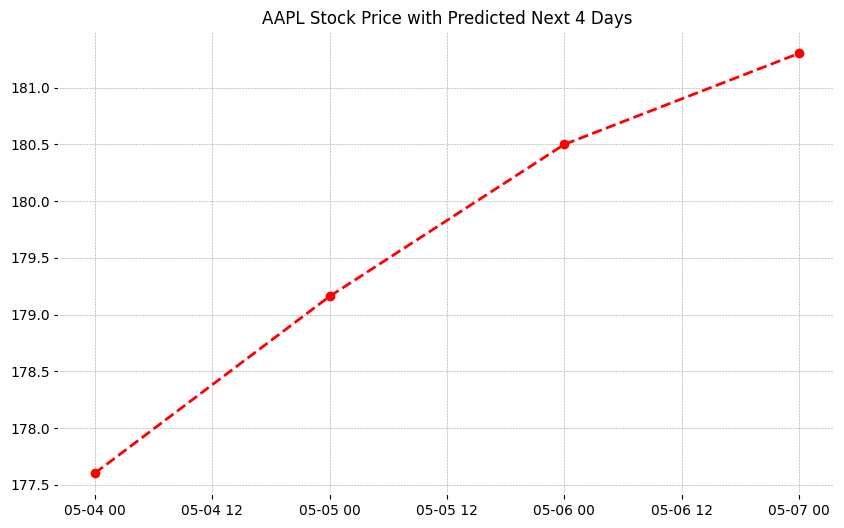

In [23]:
!pip install mplfinance -qqq
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame with the fetched AAPL stock data
# Make sure it contains Open, High, Low, Close, and Volume columns

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Assuming 'predicted_prices' is your list of predicted prices for the next 4 days
predictions_df = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Plotting the actual data with mplfinance
mpf.plot(data, type='candle', style='charles', volume=True)

# Overlaying the predicted data
plt.figure(figsize=(10,6))
plt.plot(predictions_df.index, predictions_df['Close'], linestyle='dashed', marker='o', color='red')

plt.title("AAPL Stock Price with Predicted Next 4 Days")
plt.show()

# Final Visual for Predictions:

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 28ms/step


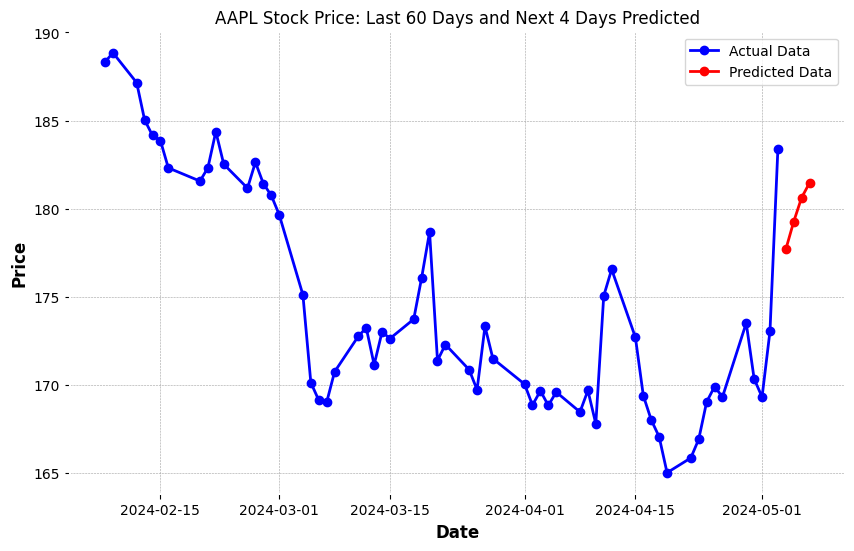

In [24]:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Fetch the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='64d', interval='1d') # Fetch 64 days to display last 60 days in the chart

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    next_prediction = model.predict(current_batch)
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Adding predictions to the DataFrame
predicted_data = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Combining both actual and predicted data
combined_data = pd.concat([data['Close'], predicted_data['Close']])
combined_data = combined_data[-64:] # Last 60 days of actual data + 4 days of predictions

# Plotting the actual data
plt.figure(figsize=(10,6))
plt.plot(data.index[-60:], data['Close'][-60:], linestyle='-', marker='o', color='blue', label='Actual Data')

# Plotting the predicted data
plt.plot(prediction_dates, predicted_prices, linestyle='-', marker='o', color='red', label='Predicted Data')

plt.title("AAPL Stock Price: Last 60 Days and Next 4 Days Predicted")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()